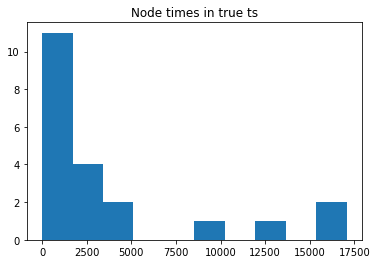

1592 mutations


In [59]:
import tsinfer
import msprime
import tskit
import tsdate

import numpy as np
import matplotlib.pyplot as plt

Ne = 10000
mu = 1e-8
historical_time = 5000
def generate_ts(
    Ne,
    mu,
    hist_time,
    rho=0, # default to no recombination
):
    samples = [
            msprime.SampleSet(1, time=hist_time, ploidy=1),
            msprime.SampleSet(5),
        ]
    ts = msprime.sim_ancestry(
        samples=samples,
        population_size=Ne,
        sequence_length=2e6,
        recombination_rate=rho,
        random_seed=1,
    )
    return msprime.mutate(ts, rate=mu, random_seed=2)

mutated_ts = generate_ts(Ne, mu, historical_time)
plt.hist(mutated_ts.nodes_time)
plt.title("Node times in true ts")
plt.show()
print(mutated_ts.num_mutations, "mutations")

In [60]:
prior = tsdate.build_prior_grid(mutated_ts, Ne=Ne, allow_historical_samples=True, truncate_priors=True, node_var_override={0:1000})

In [61]:
focal_node = 0 #mutated_ts.first().root
# Replace the prior for node 0 with a uniform prior over all timeslices
prior[focal_node] = np.concatenate(([0],np.diff(prior.timepoints)/np.max(np.diff(prior.timepoints))))
hist_prior = prior[focal_node].copy()

In [62]:
# date
dated_ts, posteriors = tsdate.date(mutated_ts, priors=prior, mutation_rate=mu, return_posteriors=True)

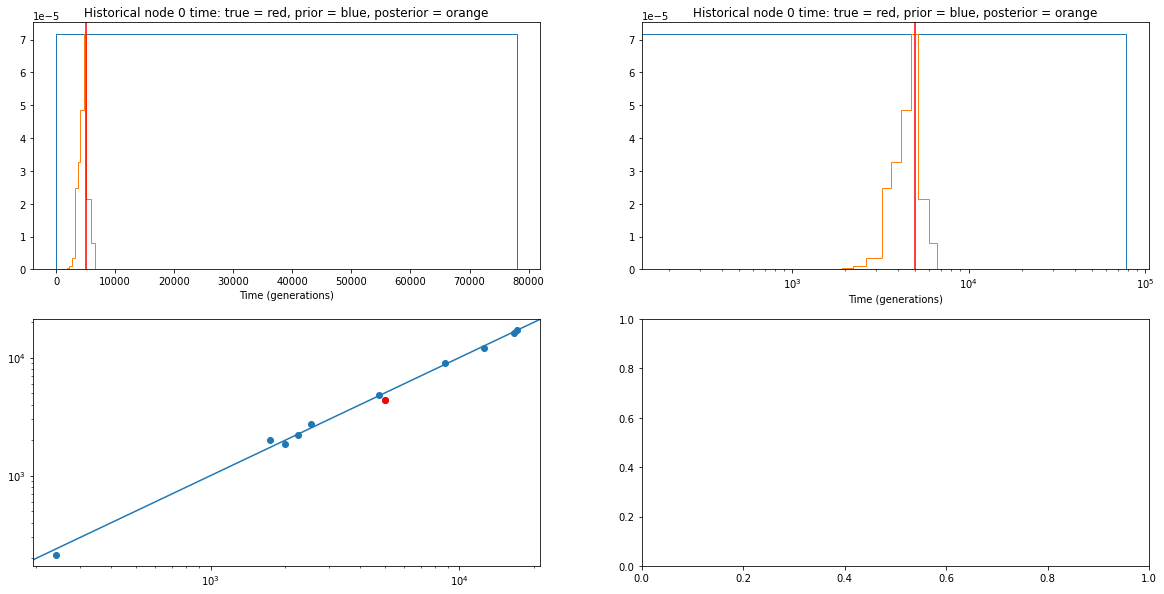

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
prior_pdf = hist_prior[1:]/np.diff(prior.timepoints)
max_prior = np.max(prior_pdf)
posterior_pdf = posteriors[focal_node]/(posteriors['end_time'] - posteriors['start_time'])
for ax in axes[0]:
    ax.stairs(prior_pdf, prior.timepoints)
    ax.stairs(posterior_pdf / max(posterior_pdf) * max_prior, np.concatenate((posteriors['start_time'][:1], posteriors['end_time'])))
    ax.axvline(mutated_ts.node(focal_node).time, c="red")
    ax.set_title(f"Historical node 0 time: true = red, prior = blue, posterior = orange")
    ax.set_xlabel(f"Time ({dated_ts.time_units})")
axes[0][1].set_xscale("log")
axes[1][0].scatter(mutated_ts.nodes_time, dated_ts.nodes_time)
axes[1][0].plot(mutated_ts.nodes_time[focal_node], dated_ts.nodes_time[focal_node], "co")
axes[1][0].set_xscale("log")
axes[1][0].set_yscale("log")
axes[1][0].axline([min(mutated_ts.nodes_time)]*2, [max(mutated_ts.nodes_time)]*2)

So historical dating works fine with this single-tree example. However, when we have multiple trees in the tree sequence, the posterior seems to be massively biased towards the second-youngest timeslice:

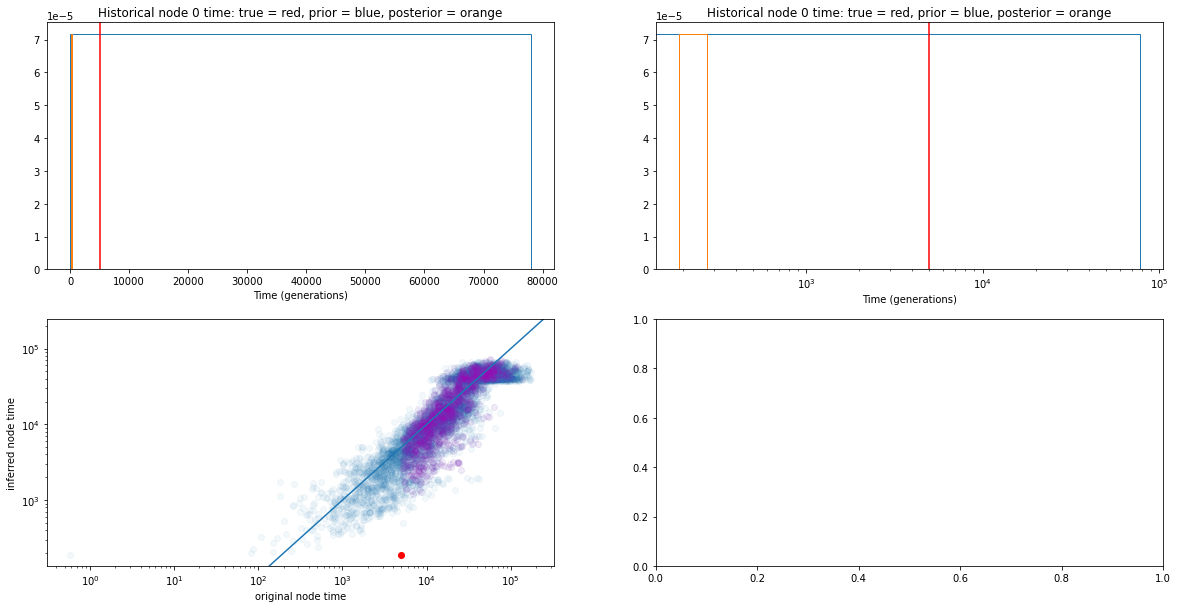

In [84]:
# repeat with rho=5e-8
mutated_ts = generate_ts(Ne, mu, historical_time, rho=5e-8)
focal_node = 0 # mutated_ts.first().root
prior = tsdate.build_prior_grid(mutated_ts, Ne=Ne, allow_historical_samples=True, truncate_priors=True, node_var_override={0:1000})
prior[focal_node] = np.concatenate(([0],np.diff(prior.timepoints)/np.max(np.diff(prior.timepoints))))
hist_prior = prior[focal_node].copy()
dated_ts, posteriors = tsdate.date(mutated_ts, priors=prior, mutation_rate=mu, return_posteriors=True)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
prior_pdf = hist_prior[1:]/np.diff(prior.timepoints)
max_prior = np.max(prior_pdf)
posterior_pdf = posteriors[focal_node]/(posteriors['end_time'] - posteriors['start_time'])
for ax in axes[0]:
    ax.stairs(prior_pdf, prior.timepoints)
    ax.stairs(posterior_pdf / max(posterior_pdf) * max_prior, np.concatenate((posteriors['start_time'][:1], posteriors['end_time'])))
    ax.axvline(mutated_ts.node(focal_node).time, c="red")
    ax.set_title(f"Historical node 0 time: true = red, prior = blue, posterior = orange")
    ax.set_xlabel(f"Time ({dated_ts.time_units})")
axes[0][1].set_xscale("log")
axes[1][0].scatter(mutated_ts.nodes_time, dated_ts.nodes_time, alpha=0.05)
parents = np.unique([e.parent for e in dated_ts.edges() if e.child == focal_node])
axes[1][0].plot(mutated_ts.nodes_time[parents], dated_ts.nodes_time[parents], "mo", alpha=0.05)
axes[1][0].plot(mutated_ts.nodes_time[focal_node], dated_ts.nodes_time[focal_node], "ro")
axes[1][0].set_xscale("log")
axes[1][0].set_yscale("log")
axes[1][0].set_xlabel("original node time")
axes[1][0].set_ylabel("inferred node time")
axes[1][0].axline([min(mutated_ts.nodes_time)]*2, [max(mutated_ts.nodes_time)]*2)

In [68]:
parents = {u: set() for u in dated_ts.samples()}
for e in dated_ts.edges():
    if e.child in dated_ts.samples():
        parents[e.child].add(e.parent)
print({k: len(v) for k, v in parents.items()})
        

{0: 1331, 1: 662, 2: 759, 3: 680, 4: 599, 5: 728, 6: 1, 7: 652, 8: 624, 9: 1, 10: 606}


In [8]:
dated_ts.node(focal_node)

Node(id=0, flags=1, time=189.70291660694068, population=0, individual=0, metadata=b'{"mn": 189.70291660694068, "vr": 1.532619216677265e-13}')

In [9]:
# The posterior has a value of 1 for the second youngest timeslice for the focal node
# and basically zero elsewhere:
posteriors[focal_node]

array([0.00000000e+000, 1.00000000e+000, 2.10408686e-017, 1.92326000e-034,
       5.63401235e-052, 5.18404845e-070, 1.44973644e-088, 1.18256920e-107,
       2.68435389e-127, 1.61096268e-147, 2.42292930e-168, 8.65955762e-190,
       7.00252850e-212, 1.23315570e-234, 4.65622347e-258, 3.88263267e-282,
       8.05929169e-307, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

In [12]:
# Parents of the focal node are a bit more sensible
psum = np.zeros_like(posteriors[focal_node])
parents = np.unique([e.parent for e in dated_ts.edges() if e.child == focal_node])
for p in parents:
    psum += posteriors[p]
print(psum/len(parents))

[0.         0.00383691 0.00778184 0.01187096 0.01615179 0.02068102
 0.02553017 0.03079048 0.03657764 0.04303815 0.05036183 0.05880629
 0.06874129 0.08072444 0.09563064 0.11489019 0.14098506 0.17864837
 0.23844815 0.16678643 0.18342285 0.20931776 0.16343765 0.29324068
 0.213065   0.33845    0.35326049 0.36663139 0.24066498 0.21294405
 0.29849191 0.22621719 0.14605572 0.27143786 0.26735515 0.27940412
 0.28189349 0.26398755 0.15661889 0.16271434 0.17016149 0.17832491
 0.18672464 0.19507835 0.20316317 0.21044165 0.21553312 0.21504427]
